In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [3]:
def get_last_layer(model_identifier):
    """
    input: model_identifier of model of which we want to find the last layer
    output: last layer identifier
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['distilgpt2','gpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            if model_identifier == 'xlnet-large-cased':
                double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            final_layer = layers[-1]
            return final_layer
            break

In [4]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['gpt2','distilgpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            if model_identifier == 'xlnet-large-cased':
                double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            if model_identifier == 'bert-large-uncased-whole-word-masking':
                double_digits = [elm for elm in layer_list if '.layer.' in elm and len(elm.split('.layer.')[-1].split('.')[0]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            return layers
            break

In [5]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split(",")[-1].split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [6]:
def get_dictionary(model_identifier, layer_identifier=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            passage_identifier = get_passage_identifier(filename)
            condition = filename.split(",")[-1].split("-")[-2]
        
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data']
            data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]
        
            if not passage_identifier in model_dictionary:
                model_dictionary[passage_identifier] = {}
            model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary

In [7]:
def get_arrays(dictionary):
    #sort dictionary by passage identifier
    sorted_dict = dict(sorted(dictionary.items()))
    #create empty arrays
    #original,scr1,scr3,scr5,scr7,lowpmi,backward,random = ([] for i in range(8))
    original,scr1,scr3,scr5,scr7,lowpmi,random = ([] for i in range(7))
    #
    for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
        original.append(value['Original'].values)
        scr1.append(value['Scr1'].values)
        scr3.append(value['Scr3'].values)
        scr5.append(value['Scr5'].values)
        scr7.append(value['Scr7'].values)
        lowpmi.append(value['lowPMI'].values)
        #backward.append(value['backward'].values)
        random.append(value['random'].values)
        
    #print(np.shape(original))
    return original,scr1,scr3,scr5,scr7,lowpmi,random #backward,random

In [8]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

In [9]:
#def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,backward,random,flatten=True):
def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,random,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'Original':np.asarray(flatten_array(original)).flatten(),
                             'Scr1':np.asarray(flatten_array(scr1)).flatten(),
                              'Scr3':np.asarray(flatten_array(scr3)).flatten(),
                              'Scr5':np.asarray(flatten_array(scr5)).flatten(),
                              'Scr7':np.asarray(flatten_array(scr7)).flatten(),
                              'lowpmi':np.asarray(flatten_array(lowpmi)).flatten(),
                              #'backward':np.asarray(flatten_array(backward)).flatten(),
                              'random':np.asarray(flatten_array(random)).flatten()})
    if not flatten:
        # print(np.shape(np.asarray(flatten_array(random))))
        df = {}
        df = {'Original':flatten_array(original),
                             'Scr1':flatten_array(scr1),
                              'Scr3':flatten_array(scr3),
                              'Scr5':flatten_array(scr5),
                              'Scr7':flatten_array(scr7),
                              'lowpmi':flatten_array(lowpmi),
                              #'backward':flatten_array(backward),
                              'random':flatten_array(random)}
    return df

In [10]:
def main_df_for_plotting(model_identifier, layer_identifier=None, flatten=True):
    model_dict = get_dictionary(model_identifier, layer_identifier)
    df = prepare_dataframe(*get_arrays(model_dict), flatten=flatten) #*flattens the tuple
    return df

In [11]:
def get_activation_dfs_for_all_layers(model_identifier, flatten=True):
    """
    input: model_identifier, whether to flatten (i.e. all sentence reps in one vector or leave 627*hidden size)
    output: dictionary: layer --> dataframe (conditions as column names, column values are flattened or unflattened activations)
    """
    layers = get_all_layers(model_identifier)
    df_dict = {}
    for ind,elm in enumerate(layers):
        df_dict[elm] = main_df_for_plotting(model_identifier,layer_identifier=elm,flatten=flatten)
    return df_dict

In [13]:
distilgpt2_correlation_dict = get_activation_dfs_for_all_layers("distilgpt2")

 25%|██▍       | 1856/7560 [00:00<00:00, 11172.15it/s]

This is the layer I'm looking at:  drop


 25%|██▍       | 1858/7560 [00:00<00:00, 17691.42it/s]

This is the layer I'm looking at:  encoder.h.0


 25%|██▍       | 1858/7560 [00:00<00:00, 18414.20it/s]

This is the layer I'm looking at:  encoder.h.1


 25%|██▍       | 1859/7560 [00:00<00:00, 17262.76it/s]

This is the layer I'm looking at:  encoder.h.2


 25%|██▍       | 1858/7560 [00:00<00:00, 18349.77it/s]

This is the layer I'm looking at:  encoder.h.3


 25%|██▍       | 1858/7560 [00:00<00:00, 18484.39it/s]

This is the layer I'm looking at:  encoder.h.4


 25%|██▍       | 1858/7560 [00:00<00:00, 18323.45it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 7560/7560 [00:13<00:00, 548.01it/s]  


In [14]:
print(distilgpt2_correlation_dict.keys())

dict_keys(['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5'])


In [15]:
print(distilgpt2_correlation_dict['drop'].shape)

(481536, 7)


In [16]:
orig_column = distilgpt2_correlation_dict['drop']['Original']
conditions = list(distilgpt2_correlation_dict['drop'].columns)

for elm in conditions:
    correlation = orig_column.corr(distilgpt2_correlation_dict['drop'][elm])
    print(elm, correlation)

print("\n")
correlations = [orig_column.corr(distilgpt2_correlation_dict['drop'][elm]) for elm in conditions]
print(correlations)

Original 0.9999999999999999
Scr1 0.9679058004422257
Scr3 0.8864662294050848
Scr5 0.8432295883930693
Scr7 0.8158436388696593
lowpmi 0.8159095183618811
random 0.6127739882677191


[0.9999999999999999, 0.9679058004422257, 0.8864662294050848, 0.8432295883930693, 0.8158436388696593, 0.8159095183618811, 0.6127739882677191]


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

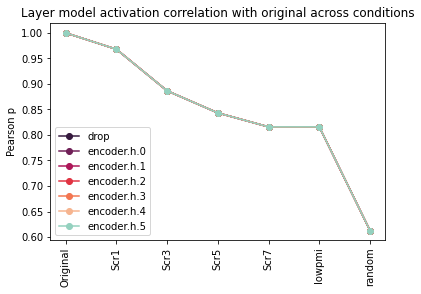

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
layers = get_all_layers("distilgpt2")
line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d")
    
x = conditions
counter = 0
for key,value in distilgpt2_correlation_dict.items():
    ax.plot(x,correlations, '-o',color=line_colors[counter])
    counter += 1

    #conditions = list(distilgpt2_score_dict.keys())

ax.set_title('Layer model activation correlation with original across conditions')
ax.legend(layers)
ax.yaxis.set_label_text('Pearson p')
plt.xticks(rotation= 90)

In [12]:
def get_correlations_df_dict(model_identifier): #maybe pass activations dict as input so it doesn't have to recompute
    layers = get_all_layers(model_identifier)
    activations_dict = get_activation_dfs_for_all_layers(model_identifier)
    
    conditions = list(activations_dict[layers[0]].columns)
    
    correlations_df_dict = {}
    for layer in layers:
        orig_column = activations_dict[layer]['Original']
        correlations = [orig_column.corr(activations_dict[layer][elm]) for elm in conditions]
        correlations_df_dict[layer] = correlations
    
    return layers, conditions, correlations_df_dict

In [19]:
layers, conditions, distilgpt2_corr_dict = get_correlations_df_dict("distilgpt2")

 25%|██▍       | 1859/7560 [00:00<00:00, 17232.89it/s]

This is the layer I'm looking at:  drop


 25%|██▍       | 1859/7560 [00:00<00:00, 17118.63it/s]

This is the layer I'm looking at:  encoder.h.0


 25%|██▍       | 1859/7560 [00:00<00:00, 17124.16it/s]

This is the layer I'm looking at:  encoder.h.1


 25%|██▍       | 1858/7560 [00:00<00:00, 18536.18it/s]

This is the layer I'm looking at:  encoder.h.2


 25%|██▍       | 1859/7560 [00:00<00:00, 17143.06it/s]

This is the layer I'm looking at:  encoder.h.3


 25%|██▍       | 1859/7560 [00:00<00:00, 16983.50it/s]

This is the layer I'm looking at:  encoder.h.4


 25%|██▍       | 1858/7560 [00:00<00:00, 18219.52it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 7560/7560 [00:13<00:00, 566.75it/s]  


In [13]:
def plot_correlations_lineplot(model_identifier, layers, conditions, correlations_dict):
    fig, ax = plt.subplots()
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
        line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
    
    layers = layers
    conditions = conditions
    
    counter = 0
    for key,value in correlations_dict.items():
        ax.plot(conditions,value, '-o',color=line_colors[counter])
        counter += 1

    ax.set_title('Layer model activation correlation with model activations for unscrambled sentence across conditions')
    if not model_identifier in ['xlnet-large-cased', 'albert-xxlarge-v2', 'bert-large-uncased-whole-word-masking']:
        ax.legend(layers)
    else:
        ax.legend(layers, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.yaxis.set_label_text('Pearson p')
    plt.xticks(rotation= 90)

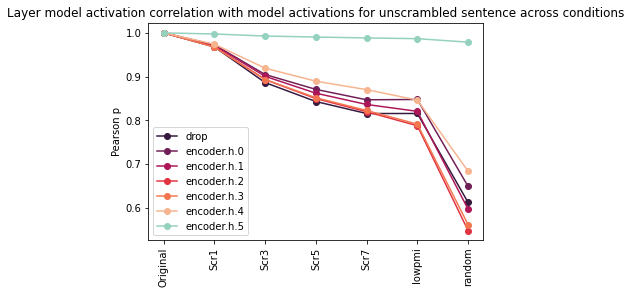

In [21]:
plot_correlations_lineplot("distilgpt2", layers, conditions, distilgpt2_corr_dict)

In [22]:
lm1b_layers, lm1b_conditions, lm1b_corr_dict = get_correlations_df_dict("lm_1b")

 80%|████████  | 6058/7560 [00:00<00:00, 56552.37it/s]

This is the layer I'm looking at:  lstm/lstm_0/control_dependency


 80%|████████  | 6060/7560 [00:00<00:00, 57355.74it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


100%|██████████| 7560/7560 [00:11<00:00, 667.89it/s]  


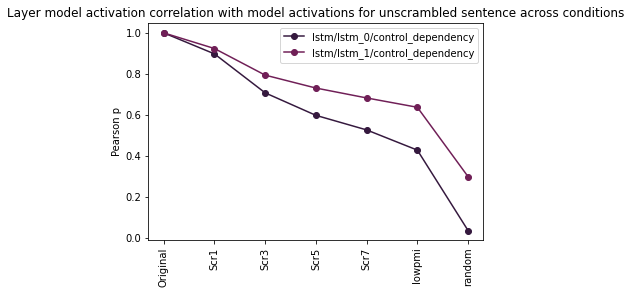

In [23]:
plot_correlations_lineplot("lm_1b", lm1b_layers, lm1b_conditions, lm1b_corr_dict)

In [14]:
skipthoughts_layers, skipthoughts_conditions, skipthoughts_corr_dict = get_correlations_df_dict("skip-thoughts")

 80%|███████▉  | 9751/12265 [00:00<00:00, 84503.46it/s]

This is the layer I'm looking at:  encoder


100%|██████████| 12265/12265 [00:21<00:00, 570.33it/s] 


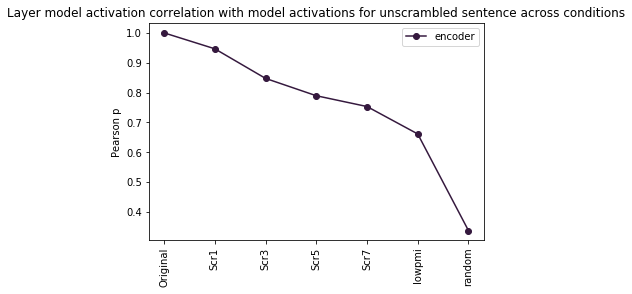

In [15]:
plot_correlations_lineplot("skip-thoughts", skipthoughts_layers, skipthoughts_conditions, skipthoughts_corr_dict)

In [24]:
gpt2_layers, gpt2_conditions, gpt2_corr_dict = get_correlations_df_dict("gpt2")

 60%|██████    | 4543/7560 [00:00<00:00, 42110.26it/s]

This is the layer I'm looking at:  drop


 60%|██████    | 4544/7560 [00:00<00:00, 42961.48it/s]

This is the layer I'm looking at:  encoder.h.0


 60%|██████    | 4544/7560 [00:00<00:00, 42520.68it/s]

This is the layer I'm looking at:  encoder.h.1


 60%|██████    | 4544/7560 [00:00<00:00, 43702.89it/s]

This is the layer I'm looking at:  encoder.h.2


 60%|██████    | 4544/7560 [00:00<00:00, 41694.56it/s]

This is the layer I'm looking at:  encoder.h.3


 60%|██████    | 4543/7560 [00:00<00:00, 26968.38it/s]

This is the layer I'm looking at:  encoder.h.4


 60%|██████    | 4544/7560 [00:00<00:00, 41811.92it/s]

This is the layer I'm looking at:  encoder.h.5


 60%|██████    | 4544/7560 [00:00<00:00, 41386.54it/s]

This is the layer I'm looking at:  encoder.h.6


 60%|██████    | 4544/7560 [00:00<00:00, 42984.54it/s]

This is the layer I'm looking at:  encoder.h.7


 60%|██████    | 4544/7560 [00:00<00:00, 41920.62it/s]

This is the layer I'm looking at:  encoder.h.8


 60%|██████    | 4544/7560 [00:00<00:00, 43267.93it/s]

This is the layer I'm looking at:  encoder.h.9


 60%|██████    | 4544/7560 [00:00<00:00, 42776.73it/s]

This is the layer I'm looking at:  encoder.h.10


 60%|██████    | 4544/7560 [00:00<00:00, 42745.75it/s]

This is the layer I'm looking at:  encoder.h.11


100%|██████████| 7560/7560 [00:19<00:00, 395.50it/s]  


In [5]:
print(get_all_layers('gpt2'))

['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5', 'encoder.h.6', 'encoder.h.7', 'encoder.h.8', 'encoder.h.9', 'encoder.h.10', 'encoder.h.11']


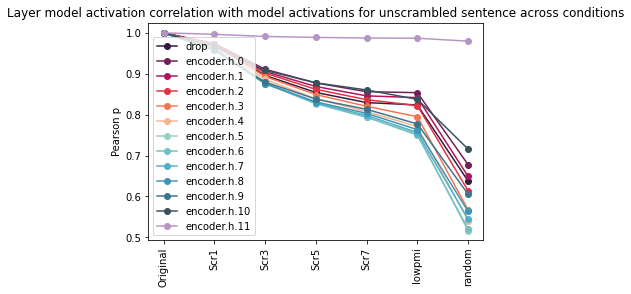

In [25]:
plot_correlations_lineplot("gpt2", gpt2_layers, gpt2_conditions, gpt2_corr_dict)

In [20]:
xlnet_layers = get_all_layers('xlnet-large-cased')
print(xlnet_layers)

['drop', 'encoder.layer.0', 'encoder.layer.1', 'encoder.layer.2', 'encoder.layer.3', 'encoder.layer.4', 'encoder.layer.5', 'encoder.layer.6', 'encoder.layer.7', 'encoder.layer.8', 'encoder.layer.9', 'encoder.layer.10', 'encoder.layer.11', 'encoder.layer.12', 'encoder.layer.13', 'encoder.layer.14', 'encoder.layer.15', 'encoder.layer.16', 'encoder.layer.17', 'encoder.layer.18', 'encoder.layer.19', 'encoder.layer.20', 'encoder.layer.21', 'encoder.layer.22', 'encoder.layer.23']


In [21]:
xlnet_layers, xlnet_conditions, xlnet_corr_dict = get_correlations_df_dict('xlnet-large-cased')


 87%|████████▋ | 8596/9936 [00:00<00:00, 80934.19it/s]

This is the layer I'm looking at:  drop



100%|██████████| 9936/9936 [00:31<00:00, 317.54it/s][A


This is the layer I'm looking at:  encoder.layer.0



100%|██████████| 9937/9937 [00:30<00:00, 326.55it/s][A

 87%|████████▋ | 8598/9937 [00:00<00:00, 72905.93it/s]

This is the layer I'm looking at:  encoder.layer.1



100%|██████████| 9937/9937 [00:31<00:00, 315.89it/s][A


This is the layer I'm looking at:  encoder.layer.2



100%|██████████| 9938/9938 [00:30<00:00, 329.21it/s][A


This is the layer I'm looking at:  encoder.layer.3



100%|██████████| 9939/9939 [00:30<00:00, 325.81it/s][A

 87%|████████▋ | 8599/9939 [00:00<00:00, 84861.31it/s]

This is the layer I'm looking at:  encoder.layer.4



100%|██████████| 9939/9939 [00:30<00:00, 321.84it/s][A


This is the layer I'm looking at:  encoder.layer.5



100%|██████████| 9940/9940 [00:30<00:00, 328.75it/s][A

 87%|████████▋ | 8601/9940 [00:00<00:00, 72050.12it/s]

This is the layer I'm looking at:  encoder.layer.6



100%|██████████| 9940/9940 [00:30<00:00, 322.58it/s][A


This is the layer I'm looking at:  encoder.layer.7



100%|██████████| 9941/9941 [00:31<00:00, 318.75it/s][A

 87%|████████▋ | 8601/9941 [00:00<00:00, 85490.73it/s]

This is the layer I'm looking at:  encoder.layer.8



100%|██████████| 9941/9941 [00:31<00:00, 318.56it/s][A


This is the layer I'm looking at:  encoder.layer.9



100%|██████████| 9942/9942 [00:30<00:00, 321.28it/s][A

 87%|████████▋ | 8602/9942 [00:00<00:00, 85954.71it/s]

This is the layer I'm looking at:  encoder.layer.10



100%|██████████| 9942/9942 [00:32<00:00, 305.71it/s][A


This is the layer I'm looking at:  encoder.layer.11



100%|██████████| 9943/9943 [00:30<00:00, 324.95it/s][A


This is the layer I'm looking at:  encoder.layer.12



100%|█████████▉| 9918/9944 [00:29<00:00, 43.06it/s]


100%|██████████| 9944/9944 [00:30<00:00, 324.81it/s][A

 87%|████████▋ | 8604/9944 [00:00<00:00, 85532.92it/s]

This is the layer I'm looking at:  encoder.layer.13



100%|██████████| 9944/9944 [00:31<00:00, 318.43it/s][A


This is the layer I'm looking at:  encoder.layer.14



100%|██████████| 9945/9945 [00:30<00:00, 324.67it/s][A


This is the layer I'm looking at:  encoder.layer.15



100%|██████████| 9946/9946 [00:31<00:00, 319.77it/s][A

 87%|████████▋ | 8606/9946 [00:00<00:00, 85235.23it/s]

This is the layer I'm looking at:  encoder.layer.16



100%|██████████| 9946/9946 [00:30<00:00, 321.46it/s][A


This is the layer I'm looking at:  encoder.layer.17



100%|██████████| 9947/9947 [00:30<00:00, 324.09it/s][A

 87%|████████▋ | 8607/9947 [00:00<00:00, 83142.46it/s]

This is the layer I'm looking at:  encoder.layer.18



100%|██████████| 9947/9947 [00:31<00:00, 311.94it/s][A


This is the layer I'm looking at:  encoder.layer.19



100%|██████████| 9948/9948 [00:30<00:00, 326.23it/s][A

 87%|████████▋ | 8609/9948 [00:00<00:00, 72985.63it/s]

This is the layer I'm looking at:  encoder.layer.20



100%|██████████| 9948/9948 [00:30<00:00, 327.00it/s][A


This is the layer I'm looking at:  encoder.layer.21



100%|██████████| 9949/9949 [00:30<00:00, 323.08it/s][A

 87%|████████▋ | 8610/9949 [00:00<00:00, 72328.91it/s]

This is the layer I'm looking at:  encoder.layer.22



100%|██████████| 9949/9949 [00:31<00:00, 314.55it/s][A


This is the layer I'm looking at:  encoder.layer.23



100%|██████████| 9950/9950 [00:31<00:00, 316.74it/s][A


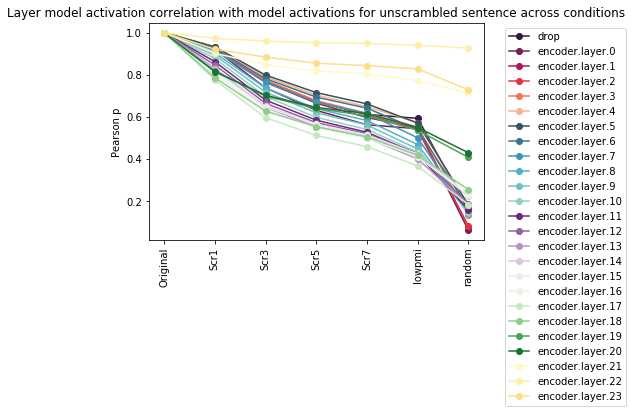

In [43]:
plot_correlations_lineplot('xlnet-large-cased', xlnet_layers, xlnet_conditions, xlnet_corr_dict)

In [62]:
get_all_layers('albert-xxlarge-v2')

['embeddings',
 'encoder.albert_layer_groups.0',
 'encoder.albert_layer_groups.1',
 'encoder.albert_layer_groups.2',
 'encoder.albert_layer_groups.3',
 'encoder.albert_layer_groups.4',
 'encoder.albert_layer_groups.5',
 'encoder.albert_layer_groups.6',
 'encoder.albert_layer_groups.7',
 'encoder.albert_layer_groups.8',
 'encoder.albert_layer_groups.9',
 'encoder.albert_layer_groups.10',
 'encoder.albert_layer_groups.11']

In [44]:
albert_layers, albert_conditions, albert_corr_dict = get_correlations_df_dict('albert-xxlarge-v2')


  0%|          | 3/9965 [00:00<07:29, 22.18it/s]

This is the layer I'm looking at:  embeddings



  8%|▊         | 756/9965 [00:40<09:42, 15.81it/s]


100%|██████████| 9965/9965 [01:14<00:00, 134.38it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.0



  8%|▊         | 787/9966 [00:39<07:26, 20.55it/s]


100%|██████████| 9966/9966 [01:10<00:00, 140.83it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.1



  9%|▊         | 862/9968 [00:41<07:29, 20.28it/s]


100%|██████████| 9968/9968 [01:06<00:00, 150.57it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.2



  8%|▊         | 835/9969 [00:41<07:12, 21.12it/s]


100%|██████████| 9969/9969 [01:05<00:00, 151.98it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.3



  9%|▉         | 899/9970 [00:42<07:21, 20.55it/s]


100%|██████████| 9970/9970 [01:03<00:00, 156.57it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.4



  9%|▉         | 902/9971 [00:42<07:13, 20.93it/s]


100%|██████████| 9971/9971 [01:03<00:00, 155.91it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.5



  9%|▉         | 904/9972 [00:42<06:59, 21.62it/s]


100%|██████████| 9972/9972 [01:04<00:00, 155.80it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.6



  8%|▊         | 819/9973 [00:41<07:43, 19.77it/s]


100%|██████████| 9973/9973 [01:09<00:00, 143.33it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.7



  8%|▊         | 778/9974 [00:38<07:32, 20.31it/s]


100%|██████████| 9974/9974 [01:07<00:00, 148.85it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.8



  9%|▉         | 898/9975 [00:42<07:18, 20.69it/s]


100%|██████████| 9975/9975 [01:04<00:00, 153.73it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.9



  9%|▊         | 871/9977 [00:42<09:20, 16.26it/s]


100%|██████████| 9977/9977 [01:07<00:00, 147.06it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.10



  9%|▉         | 882/9978 [00:42<07:01, 21.58it/s]


100%|██████████| 9978/9978 [01:05<00:00, 153.44it/s][A


This is the layer I'm looking at:  encoder.albert_layer_groups.11



  8%|▊         | 771/9980 [00:39<07:04, 21.71it/s]


100%|██████████| 9980/9980 [01:07<00:00, 148.81it/s][A


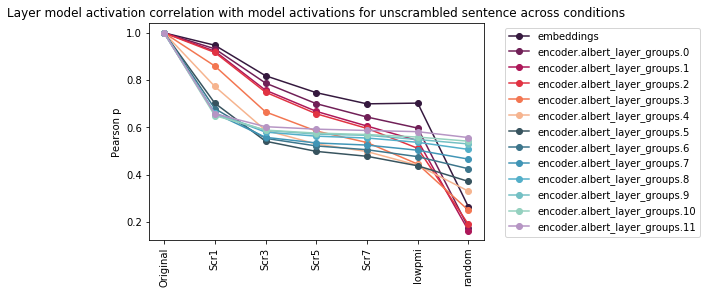

In [48]:
plot_correlations_lineplot('albert-xxlarge-v2', albert_layers, albert_conditions, albert_corr_dict)

In [64]:
bert_layers = get_all_layers('bert-large-uncased-whole-word-masking')
print(bert_layers)

['embedding', 'encoder.layer.0.output', 'encoder.layer.1.output', 'encoder.layer.2.output', 'encoder.layer.3.output', 'encoder.layer.4.output', 'encoder.layer.5.output', 'encoder.layer.6.output', 'encoder.layer.7.output', 'encoder.layer.8.output', 'encoder.layer.9.output', 'encoder.layer.10.output', 'encoder.layer.11.output', 'encoder.layer.12.output', 'encoder.layer.13.output', 'encoder.layer.14.output', 'encoder.layer.15.output', 'encoder.layer.16.output', 'encoder.layer.17.output', 'encoder.layer.18.output', 'encoder.layer.19.output', 'encoder.layer.20.output', 'encoder.layer.21.output', 'encoder.layer.22.output', 'encoder.layer.23.output']


In [66]:
bert_layers, bert_conditions, bert_corr_dict = get_correlations_df_dict('bert-large-uncased-whole-word-masking')



  0%|          | 0/11232 [00:00<?, ?it/s]

This is the layer I'm looking at:  embedding




 12%|█▏        | 1345/11232 [00:00<00:03, 2861.67it/s]

 13%|█▎        | 1431/11232 [00:02<01:28, 110.47it/s] 

 13%|█▎        | 1493/11232 [00:04<02:28, 65.60it/s] 

 14%|█▎        | 1537/11232 [00:05<02:48, 57.55it/s]

 14%|█▍        | 1569/11232 [00:06<03:02, 52.91it/s]

 14%|█▍        | 1593/11232 [00:07<03:12, 50.02it/s]

 14%|█▍        | 1611/11232 [00:07<03:27, 46.41it/s]

 14%|█▍        | 1625/11232 [00:07<03:31, 45.44it/s]

 15%|█▍        | 1636/11232 [00:08<03:38, 43.88it/s]

 15%|█▍        | 1645/11232 [00:08<03:41, 43.23it/s]

 15%|█▍        | 1653/11232 [00:08<03:42, 43.09it/s]

 15%|█▍        | 1660/11232 [00:08<03:43, 42.89it/s]

 15%|█▍        | 1666/11232 [00:08<03:44, 42.68it/s]

 15%|█▍        | 1672/11232 [00:08<03:45, 42.45it/s]

 15%|█▍        | 1677/11232 [00:09<03:47, 41.95it/s]

 15%|█▍        | 1682/11232 [00:09<03:47, 42.00it/s]

 15%|█▌        | 1687/11232 [00:09<03:47, 41.90it/s]

 15%|█▌        | 1692/11232 [00:09<03:47, 41.93it/s]

 15%|█▌        | 1697

This is the layer I'm looking at:  encoder.layer.0.output




  0%|          | 0/11233 [00:00<?, ?it/s]

 12%|█▏        | 1347/11233 [00:00<00:00, 10872.03it/s]

 15%|█▍        | 1674/11233 [00:08<01:16, 124.25it/s]  

 17%|█▋        | 1904/11233 [00:15<02:18, 67.31it/s] 

 18%|█▊        | 2066/11233 [00:20<02:59, 51.15it/s]

 19%|█▉        | 2181/11233 [00:24<03:28, 43.42it/s]

 20%|██        | 2262/11233 [00:26<03:46, 39.52it/s]

 21%|██        | 2320/11233 [00:28<04:00, 37.11it/s]

 21%|██        | 2362/11233 [00:29<04:09, 35.57it/s]

 21%|██▏       | 2392/11233 [00:30<04:15, 34.60it/s]

 21%|██▏       | 2414/11233 [00:31<04:19, 33.96it/s]

 22%|██▏       | 2431/11233 [00:32<04:23, 33.36it/s]

 22%|██▏       | 2444/11233 [00:32<04:30, 32.54it/s]

 22%|██▏       | 2454/11233 [00:32<04:34, 32.03it/s]

 22%|██▏       | 2462/11233 [00:33<04:36, 31.70it/s]

 22%|██▏       | 2469/11233 [00:33<04:37, 31.60it/s]

 22%|██▏       | 2475/11233 [00:33<04:41, 31.15it/s]

 22%|██▏       | 2480/11233 [00:33<04:42, 31.02it/s]

 22%|██▏       | 2485/11233 [0

This is the layer I'm looking at:  encoder.layer.1.output




  0%|          | 0/11234 [00:00<?, ?it/s]

 12%|█▏        | 1348/11234 [00:00<00:00, 11309.72it/s]

 15%|█▌        | 1688/11234 [00:10<01:27, 109.56it/s]  

 15%|█▌        | 1692/11234 [00:10<02:39, 59.96it/s] 

 15%|█▌        | 1696/11234 [00:10<03:26, 46.19it/s]

 15%|█▌        | 1700/11234 [00:10<04:06, 38.75it/s]

 15%|█▌        | 1704/11234 [00:10<04:26, 35.80it/s]

 15%|█▌        | 1708/11234 [00:11<04:39, 34.05it/s]

 15%|█▌        | 1712/11234 [00:11<04:47, 33.08it/s]

 15%|█▌        | 1716/11234 [00:11<04:53, 32.46it/s]

 15%|█▌        | 1720/11234 [00:11<04:57, 32.00it/s]

 15%|█▌        | 1724/11234 [00:11<05:03, 31.37it/s]

 15%|█▌        | 1728/11234 [00:11<05:07, 30.91it/s]

 15%|█▌        | 1732/11234 [00:11<05:09, 30.70it/s]

 15%|█▌        | 1736/11234 [00:11<05:09, 30.70it/s]

 15%|█▌        | 1740/11234 [00:12<05:09, 30.71it/s]

 16%|█▌        | 1744/11234 [00:12<05:10, 30.59it/s]

 16%|█▌        | 1748/11234 [00:12<05:11, 30.48it/s]

 16%|█▌        | 1752/11234 [0

This is the layer I'm looking at:  encoder.layer.2.output




  0%|          | 0/11235 [00:00<?, ?it/s]

 12%|█▏        | 1347/11235 [00:00<00:00, 10980.54it/s]

 15%|█▍        | 1677/11235 [00:08<01:17, 123.16it/s]  

 17%|█▋        | 1909/11235 [00:14<01:58, 78.98it/s] 

 18%|█▊        | 2073/11235 [00:18<02:25, 62.80it/s]

 19%|█▉        | 2189/11235 [00:21<02:49, 53.46it/s]

 20%|██        | 2272/11235 [00:23<03:18, 45.26it/s]

 21%|██        | 2331/11235 [00:25<03:38, 40.67it/s]

 21%|██        | 2373/11235 [00:26<03:58, 37.18it/s]

 21%|██▏       | 2404/11235 [00:27<04:06, 35.80it/s]

 22%|██▏       | 2427/11235 [00:28<04:12, 34.85it/s]

 22%|██▏       | 2444/11235 [00:28<04:11, 34.91it/s]

 22%|██▏       | 2457/11235 [00:29<03:57, 37.00it/s]

 22%|██▏       | 2468/11235 [00:29<03:46, 38.66it/s]

 22%|██▏       | 2477/11235 [00:29<03:38, 40.07it/s]

 22%|██▏       | 2485/11235 [00:29<03:36, 40.44it/s]

 22%|██▏       | 2492/11235 [00:30<03:33, 40.89it/s]

 22%|██▏       | 2498/11235 [00:30<03:31, 41.36it/s]

 22%|██▏       | 2504/11235 [0

This is the layer I'm looking at:  encoder.layer.3.output




 15%|█▌        | 1714/11235 [00:09<01:13, 129.88it/s]  

 18%|█▊        | 1971/11235 [00:16<02:02, 75.73it/s] 

 19%|█▉        | 2152/11235 [00:20<02:33, 59.17it/s]

 20%|██        | 2280/11235 [00:23<02:47, 53.35it/s]

 21%|██        | 2371/11235 [00:25<02:59, 49.29it/s]

 22%|██▏       | 2436/11235 [00:27<03:07, 46.84it/s]

 22%|██▏       | 2483/11235 [00:28<03:12, 45.58it/s]

 22%|██▏       | 2517/11235 [00:29<03:14, 44.73it/s]

 23%|██▎       | 2542/11235 [00:30<03:37, 39.88it/s]

 23%|██▎       | 2561/11235 [00:30<03:56, 36.68it/s]

 23%|██▎       | 2575/11235 [00:31<04:11, 34.48it/s]

 23%|██▎       | 2586/11235 [00:31<04:19, 33.32it/s]

 23%|██▎       | 2595/11235 [00:31<04:25, 32.50it/s]

 23%|██▎       | 2602/11235 [00:32<04:29, 32.08it/s]

 23%|██▎       | 2608/11235 [00:32<04:34, 31.48it/s]

 23%|██▎       | 2613/11235 [00:32<04:36, 31.20it/s]

 23%|██▎       | 2618/11235 [00:32<04:39, 30.84it/s]

 23%|██▎       | 2622/11235 [00:32<04:43, 30.38it/s]

 23%|██▎       | 2626/

This is the layer I'm looking at:  encoder.layer.4.output




  0%|          | 0/11236 [00:00<?, ?it/s]

 12%|█▏        | 1347/11236 [00:00<00:00, 12349.43it/s]

 15%|█▌        | 1718/11236 [00:09<01:15, 126.08it/s]  

 18%|█▊        | 1979/11236 [00:15<01:55, 80.10it/s] 

 19%|█▉        | 2163/11236 [00:20<02:24, 62.95it/s]

 20%|██        | 2293/11236 [00:23<02:41, 55.42it/s]

 21%|██        | 2386/11236 [00:25<03:06, 47.50it/s]

 22%|██▏       | 2452/11236 [00:27<03:29, 41.94it/s]

 22%|██▏       | 2499/11236 [00:29<03:37, 40.25it/s]

 23%|██▎       | 2533/11236 [00:30<03:38, 39.90it/s]

 23%|██▎       | 2558/11236 [00:30<03:33, 40.60it/s]

 23%|██▎       | 2577/11236 [00:31<03:30, 41.22it/s]

 23%|██▎       | 2592/11236 [00:31<03:26, 41.94it/s]

 23%|██▎       | 2604/11236 [00:31<03:24, 42.31it/s]

 23%|██▎       | 2614/11236 [00:31<03:22, 42.65it/s]

 23%|██▎       | 2622/11236 [00:32<03:21, 42.75it/s]

 23%|██▎       | 2629/11236 [00:32<03:23, 42.32it/s]

 23%|██▎       | 2635/11236 [00:32<03:25, 41.80it/s]

 24%|██▎       | 2641/11236 [0

This is the layer I'm looking at:  encoder.layer.5.output




  0%|          | 0/11237 [00:00<?, ?it/s]

 12%|█▏        | 1347/11237 [00:00<00:00, 12817.13it/s]

 15%|█▌        | 1732/11237 [00:11<01:25, 111.00it/s]  

 15%|█▌        | 1736/11237 [00:11<02:32, 62.17it/s] 

 15%|█▌        | 1740/11237 [00:11<03:19, 47.50it/s]

 16%|█▌        | 1744/11237 [00:11<03:51, 40.96it/s]

 16%|█▌        | 1748/11237 [00:12<04:16, 36.94it/s]

 16%|█▌        | 1752/11237 [00:12<04:32, 34.82it/s]

 16%|█▌        | 1756/11237 [00:12<04:42, 33.58it/s]

 16%|█▌        | 1760/11237 [00:12<04:49, 32.78it/s]

 16%|█▌        | 1764/11237 [00:12<04:54, 32.18it/s]

 16%|█▌        | 1768/11237 [00:12<04:57, 31.82it/s]

 16%|█▌        | 1772/11237 [00:12<04:59, 31.59it/s]

 16%|█▌        | 1776/11237 [00:13<05:00, 31.43it/s]

 16%|█▌        | 1780/11237 [00:13<05:01, 31.33it/s]

 16%|█▌        | 1784/11237 [00:13<05:03, 31.16it/s]

 16%|█▌        | 1788/11237 [00:13<05:02, 31.20it/s]

 16%|█▌        | 1792/11237 [00:13<05:02, 31.24it/s]

 16%|█▌        | 1796/11237 [0

This is the layer I'm looking at:  encoder.layer.6.output




 15%|█▍        | 1679/11237 [00:09<01:25, 111.18it/s]  

 17%|█▋        | 1912/11237 [00:17<02:23, 65.12it/s] 

 18%|█▊        | 2076/11237 [00:22<03:04, 49.72it/s]

 20%|█▉        | 2192/11237 [00:25<03:22, 44.67it/s]

 20%|██        | 2274/11237 [00:27<03:26, 43.33it/s]

 21%|██        | 2333/11237 [00:29<03:46, 39.36it/s]

 21%|██        | 2375/11237 [00:30<04:05, 36.16it/s]

 21%|██▏       | 2406/11237 [00:31<04:12, 34.96it/s]

 22%|██▏       | 2429/11237 [00:32<04:19, 33.97it/s]

 22%|██▏       | 2446/11237 [00:32<04:24, 33.28it/s]

 22%|██▏       | 2459/11237 [00:33<04:28, 32.69it/s]

 22%|██▏       | 2469/11237 [00:33<04:33, 32.04it/s]

 22%|██▏       | 2477/11237 [00:33<04:37, 31.54it/s]

 22%|██▏       | 2484/11237 [00:34<04:40, 31.26it/s]

 22%|██▏       | 2490/11237 [00:34<04:43, 30.88it/s]

 22%|██▏       | 2495/11237 [00:34<04:46, 30.53it/s]

 22%|██▏       | 2500/11237 [00:34<04:46, 30.54it/s]

 22%|██▏       | 2504/11237 [00:34<04:48, 30.31it/s]

 22%|██▏       | 2508/

This is the layer I'm looking at:  encoder.layer.7.output




  0%|          | 0/11238 [00:00<?, ?it/s]

 12%|█▏        | 1348/11238 [00:00<00:00, 11054.09it/s]

 15%|█▍        | 1680/11238 [00:08<01:16, 125.24it/s]  

 17%|█▋        | 1914/11238 [00:14<01:55, 80.46it/s] 

 18%|█▊        | 2079/11238 [00:18<02:24, 63.21it/s]

 20%|█▉        | 2196/11238 [00:20<02:41, 56.09it/s]

 20%|██        | 2279/11238 [00:23<03:15, 45.91it/s]

 21%|██        | 2338/11238 [00:25<03:36, 41.14it/s]

 21%|██        | 2381/11238 [00:26<03:51, 38.19it/s]

 21%|██▏       | 2412/11238 [00:27<03:51, 38.09it/s]

 22%|██▏       | 2435/11238 [00:27<03:45, 39.06it/s]

 22%|██▏       | 2453/11238 [00:28<03:41, 39.64it/s]

 22%|██▏       | 2467/11238 [00:28<03:39, 40.00it/s]

 22%|██▏       | 2478/11238 [00:28<03:36, 40.46it/s]

 22%|██▏       | 2487/11238 [00:29<03:35, 40.53it/s]

 22%|██▏       | 2495/11238 [00:29<03:34, 40.69it/s]

 22%|██▏       | 2502/11238 [00:29<03:34, 40.82it/s]

 22%|██▏       | 2508/11238 [00:29<03:33, 40.83it/s]

 22%|██▏       | 2514/11238 [0

This is the layer I'm looking at:  encoder.layer.8.output




  0%|          | 0/11239 [00:00<?, ?it/s]

 12%|█▏        | 1347/11239 [00:00<00:00, 11671.13it/s]

 15%|█▌        | 1698/11239 [00:08<01:09, 136.70it/s]  

 17%|█▋        | 1945/11239 [00:15<02:03, 75.38it/s] 

 19%|█▉        | 2119/11239 [00:19<02:27, 61.90it/s]

 20%|█▉        | 2242/11239 [00:22<02:45, 54.41it/s]

 21%|██        | 2330/11239 [00:24<02:54, 50.97it/s]

 21%|██▏       | 2393/11239 [00:25<03:02, 48.39it/s]

 22%|██▏       | 2438/11239 [00:26<03:12, 45.61it/s]

 22%|██▏       | 2471/11239 [00:27<03:35, 40.60it/s]

 22%|██▏       | 2495/11239 [00:28<03:52, 37.60it/s]

 22%|██▏       | 2513/11239 [00:29<04:03, 35.90it/s]

 22%|██▏       | 2527/11239 [00:29<04:13, 34.43it/s]

 23%|██▎       | 2538/11239 [00:29<04:19, 33.56it/s]

 23%|██▎       | 2547/11239 [00:30<04:21, 33.24it/s]

 23%|██▎       | 2554/11239 [00:30<04:22, 33.03it/s]

 23%|██▎       | 2560/11239 [00:30<04:26, 32.57it/s]

 23%|██▎       | 2565/11239 [00:30<04:31, 31.92it/s]

 23%|██▎       | 2570/11239 [0

This is the layer I'm looking at:  encoder.layer.9.output




  0%|          | 0/11240 [00:00<?, ?it/s]

 12%|█▏        | 1348/11240 [00:00<00:00, 12944.26it/s]

 15%|█▌        | 1737/11240 [00:09<01:09, 137.32it/s]  

 18%|█▊        | 2011/11240 [00:15<01:52, 81.85it/s] 

 20%|█▉        | 2204/11240 [00:21<02:28, 60.69it/s]

 21%|██        | 2340/11240 [00:24<02:54, 50.95it/s]

 22%|██▏       | 2437/11240 [00:27<03:02, 48.23it/s]

 22%|██▏       | 2506/11240 [00:28<03:05, 47.06it/s]

 23%|██▎       | 2556/11240 [00:29<03:08, 46.05it/s]

 23%|██▎       | 2592/11240 [00:30<03:19, 43.25it/s]

 23%|██▎       | 2619/11240 [00:31<03:20, 43.07it/s]

 23%|██▎       | 2639/11240 [00:31<03:18, 43.23it/s]

 24%|██▎       | 2655/11240 [00:32<03:18, 43.30it/s]

 24%|██▎       | 2667/11240 [00:32<03:18, 43.30it/s]

 24%|██▍       | 2677/11240 [00:32<03:18, 43.22it/s]

100%|██████████| 11240/11240 [00:32<00:00, 341.72it/s]A


  0%|          | 0/11240 [00:00<?, ?it/s]

 12%|█▏        | 1349/11240 [00:00<00:00, 11470.09it/s]

This is the layer I'm looking at:  encoder.layer.10.output




 15%|█▌        | 1694/11240 [00:09<01:17, 122.85it/s]  

 17%|█▋        | 1936/11240 [00:16<02:09, 71.60it/s] 

 19%|█▊        | 2107/11240 [00:20<02:33, 59.64it/s]

 20%|█▉        | 2228/11240 [00:22<02:48, 53.36it/s]

 21%|██        | 2314/11240 [00:25<03:08, 47.28it/s]

 21%|██        | 2376/11240 [00:26<03:18, 44.75it/s]

 22%|██▏       | 2420/11240 [00:27<03:21, 43.75it/s]

 22%|██▏       | 2453/11240 [00:28<03:24, 43.04it/s]

 22%|██▏       | 2477/11240 [00:29<03:24, 42.87it/s]

 22%|██▏       | 2495/11240 [00:29<03:24, 42.66it/s]

 22%|██▏       | 2509/11240 [00:29<03:25, 42.49it/s]

 22%|██▏       | 2520/11240 [00:30<03:28, 41.84it/s]

 22%|██▎       | 2529/11240 [00:30<03:30, 41.32it/s]

 23%|██▎       | 2537/11240 [00:30<03:31, 41.06it/s]

 23%|██▎       | 2544/11240 [00:30<03:48, 38.12it/s]

 23%|██▎       | 2550/11240 [00:31<04:39, 31.06it/s]

 23%|██▎       | 2555/11240 [00:31<04:50, 29.88it/s]

 23%|██▎       | 2559/11240 [00:31<04:49, 29.96it/s]

 23%|██▎       | 2563/

This is the layer I'm looking at:  encoder.layer.11.output




  0%|          | 0/11241 [00:00<?, ?it/s]

 12%|█▏        | 1348/11241 [00:00<00:00, 10845.46it/s]

 15%|█▍        | 1674/11241 [00:08<01:10, 135.92it/s]  

 17%|█▋        | 1903/11241 [00:13<01:52, 83.05it/s] 

 18%|█▊        | 2065/11241 [00:16<02:19, 65.70it/s]

 19%|█▉        | 2180/11241 [00:19<02:38, 56.99it/s]

 20%|██        | 2262/11241 [00:21<02:51, 52.35it/s]

 21%|██        | 2321/11241 [00:22<03:00, 49.49it/s]

 21%|██        | 2364/11241 [00:23<03:06, 47.70it/s]

 21%|██▏       | 2395/11241 [00:24<03:10, 46.44it/s]

 22%|██▏       | 2418/11241 [00:25<03:13, 45.54it/s]

 22%|██▏       | 2436/11241 [00:25<03:15, 44.93it/s]

 22%|██▏       | 2450/11241 [00:25<03:17, 44.50it/s]

 22%|██▏       | 2461/11241 [00:26<03:18, 44.12it/s]

 22%|██▏       | 2470/11241 [00:26<03:26, 42.49it/s]

 22%|██▏       | 2478/11241 [00:26<03:45, 38.78it/s]

 22%|██▏       | 2485/11241 [00:26<03:59, 36.55it/s]

 22%|██▏       | 2491/11241 [00:26<04:45, 30.68it/s]

 22%|██▏       | 2496/11241 [0

This is the layer I'm looking at:  encoder.layer.12.output




 15%|█▌        | 1689/11241 [00:08<01:07, 141.27it/s]  

 17%|█▋        | 1929/11241 [00:13<01:49, 84.93it/s] 

 19%|█▊        | 2098/11241 [00:17<02:19, 65.58it/s]

 20%|█▉        | 2218/11241 [00:20<02:44, 54.93it/s]

 20%|██        | 2303/11241 [00:22<02:55, 50.83it/s]

 21%|██        | 2364/11241 [00:23<03:04, 48.22it/s]

 21%|██▏       | 2408/11241 [00:24<03:14, 45.47it/s]

 22%|██▏       | 2440/11241 [00:25<03:17, 44.50it/s]

 22%|██▏       | 2464/11241 [00:26<03:21, 43.64it/s]

 22%|██▏       | 2482/11241 [00:26<03:22, 43.24it/s]

 22%|██▏       | 2496/11241 [00:27<03:23, 42.87it/s]

 22%|██▏       | 2507/11241 [00:27<03:25, 42.51it/s]

 22%|██▏       | 2516/11241 [00:27<03:26, 42.23it/s]

 22%|██▏       | 2524/11241 [00:27<03:27, 42.05it/s]

 23%|██▎       | 2531/11241 [00:27<03:27, 41.98it/s]

 23%|██▎       | 2537/11241 [00:28<03:28, 41.80it/s]

 23%|██▎       | 2543/11241 [00:28<03:28, 41.68it/s]

 23%|██▎       | 2548/11241 [00:28<03:28, 41.65it/s]

 23%|██▎       | 2553/

This is the layer I'm looking at:  encoder.layer.13.output




  0%|          | 0/11242 [00:00<?, ?it/s]

 12%|█▏        | 1349/11242 [00:00<00:00, 11806.88it/s]

 15%|█▌        | 1704/11242 [00:08<01:08, 139.62it/s]  

 17%|█▋        | 1954/11242 [00:14<01:50, 84.07it/s] 

 19%|█▉        | 2130/11242 [00:18<02:22, 63.73it/s]

 20%|██        | 2255/11242 [00:21<02:50, 52.86it/s]

 21%|██        | 2344/11242 [00:24<03:03, 48.55it/s]

 21%|██▏       | 2407/11242 [00:25<03:07, 47.09it/s]

 22%|██▏       | 2453/11242 [00:26<03:10, 46.14it/s]

 22%|██▏       | 2487/11242 [00:27<03:12, 45.56it/s]

 22%|██▏       | 2512/11242 [00:27<03:13, 45.05it/s]

 23%|██▎       | 2531/11242 [00:28<03:14, 44.73it/s]

 23%|██▎       | 2546/11242 [00:28<03:15, 44.37it/s]

 23%|██▎       | 2558/11242 [00:28<03:17, 43.86it/s]

 23%|██▎       | 2568/11242 [00:29<03:18, 43.70it/s]

 23%|██▎       | 2576/11242 [00:29<03:19, 43.36it/s]

 23%|██▎       | 2583/11242 [00:29<03:23, 42.53it/s]

 23%|██▎       | 2589/11242 [00:29<03:44, 38.59it/s]

 23%|██▎       | 2595/11242 [0

This is the layer I'm looking at:  encoder.layer.14.output




  0%|          | 0/11243 [00:00<?, ?it/s]

 12%|█▏        | 1347/11243 [00:00<00:00, 12367.46it/s]

 15%|█▌        | 1719/11243 [00:08<01:08, 140.00it/s]  

 18%|█▊        | 1980/11243 [00:14<01:50, 84.15it/s] 

 19%|█▉        | 2164/11243 [00:19<02:17, 66.15it/s]

 20%|██        | 2295/11243 [00:22<02:36, 57.09it/s]

 21%|██        | 2388/11243 [00:24<02:48, 52.42it/s]

 22%|██▏       | 2454/11243 [00:25<02:57, 49.60it/s]

 22%|██▏       | 2502/11243 [00:27<03:17, 44.33it/s]

 23%|██▎       | 2537/11243 [00:27<03:15, 44.47it/s]

 23%|██▎       | 2563/11243 [00:28<03:15, 44.32it/s]

 23%|██▎       | 2583/11243 [00:28<03:16, 44.12it/s]

 23%|██▎       | 2598/11243 [00:29<03:29, 41.34it/s]

 23%|██▎       | 2610/11243 [00:29<03:26, 41.72it/s]

 23%|██▎       | 2620/11243 [00:29<03:25, 41.99it/s]

 23%|██▎       | 2628/11243 [00:29<03:24, 42.06it/s]

 23%|██▎       | 2635/11243 [00:30<03:24, 42.17it/s]

 23%|██▎       | 2641/11243 [00:30<03:24, 42.03it/s]

 24%|██▎       | 2647/11243 [0

This is the layer I'm looking at:  encoder.layer.15.output




 15%|█▌        | 1709/11243 [00:08<01:04, 147.24it/s]  

 17%|█▋        | 1962/11243 [00:13<01:47, 86.13it/s] 

 19%|█▉        | 2141/11243 [00:18<02:15, 67.03it/s]

 20%|██        | 2268/11243 [00:20<02:35, 57.54it/s]

 21%|██        | 2358/11243 [00:22<02:48, 52.80it/s]

 22%|██▏       | 2422/11243 [00:24<02:56, 49.84it/s]

 22%|██▏       | 2469/11243 [00:25<03:03, 47.76it/s]

 22%|██▏       | 2503/11243 [00:26<03:07, 46.57it/s]

 22%|██▏       | 2528/11243 [00:26<03:10, 45.74it/s]

 23%|██▎       | 2547/11243 [00:27<03:13, 44.88it/s]

 23%|██▎       | 2562/11243 [00:27<03:16, 44.18it/s]

 23%|██▎       | 2574/11243 [00:28<03:33, 40.65it/s]

 23%|██▎       | 2583/11243 [00:28<03:31, 41.02it/s]

 23%|██▎       | 2591/11243 [00:28<03:30, 41.19it/s]

 23%|██▎       | 2598/11243 [00:28<03:38, 39.53it/s]

 23%|██▎       | 2604/11243 [00:28<03:56, 36.53it/s]

 23%|██▎       | 2609/11243 [00:28<04:08, 34.81it/s]

 23%|██▎       | 2614/11243 [00:29<04:16, 33.62it/s]

 23%|██▎       | 2618/

This is the layer I'm looking at:  encoder.layer.16.output




  0%|          | 0/11244 [00:00<?, ?it/s]

 12%|█▏        | 1347/11244 [00:00<00:00, 13287.63it/s]

 16%|█▌        | 1746/11244 [00:09<01:07, 140.97it/s]  

 18%|█▊        | 2027/11244 [00:15<01:48, 85.06it/s] 

 20%|█▉        | 2225/11244 [00:20<02:15, 66.38it/s]

 21%|██        | 2365/11244 [00:23<02:33, 57.69it/s]

 22%|██▏       | 2465/11244 [00:25<02:46, 52.78it/s]

 23%|██▎       | 2536/11244 [00:27<03:15, 44.53it/s]

 23%|██▎       | 2587/11244 [00:29<03:33, 40.57it/s]

 23%|██▎       | 2624/11244 [00:30<03:27, 41.58it/s]

 24%|██▎       | 2651/11244 [00:30<03:23, 42.22it/s]

 24%|██▍       | 2672/11244 [00:31<03:20, 42.65it/s]

100%|██████████| 11244/11244 [00:31<00:00, 353.64it/s]A


  0%|          | 0/11244 [00:00<?, ?it/s]

 12%|█▏        | 1349/11244 [00:00<00:00, 12300.44it/s]

This is the layer I'm looking at:  encoder.layer.17.output




 15%|█▌        | 1719/11244 [00:08<01:06, 142.76it/s]  

 18%|█▊        | 1979/11244 [00:14<01:49, 84.26it/s] 

 19%|█▉        | 2163/11244 [00:18<02:17, 65.85it/s]

 20%|██        | 2293/11244 [00:21<02:36, 57.22it/s]

 21%|██        | 2385/11244 [00:24<02:50, 52.03it/s]

 22%|██▏       | 2451/11244 [00:26<03:18, 44.30it/s]

 22%|██▏       | 2498/11244 [00:27<03:43, 39.10it/s]

 23%|██▎       | 2532/11244 [00:28<03:54, 37.10it/s]

 23%|██▎       | 2557/11244 [00:29<03:44, 38.66it/s]

 23%|██▎       | 2576/11244 [00:29<03:37, 39.78it/s]

 23%|██▎       | 2591/11244 [00:29<03:33, 40.56it/s]

 23%|██▎       | 2603/11244 [00:30<03:31, 40.93it/s]

 23%|██▎       | 2613/11244 [00:30<03:29, 41.25it/s]

 23%|██▎       | 2621/11244 [00:30<03:28, 41.46it/s]

 23%|██▎       | 2628/11244 [00:30<03:27, 41.50it/s]

 23%|██▎       | 2634/11244 [00:31<03:27, 41.48it/s]

 23%|██▎       | 2640/11244 [00:31<03:27, 41.39it/s]

 24%|██▎       | 2645/11244 [00:31<03:28, 41.34it/s]

 24%|██▎       | 2650/

This is the layer I'm looking at:  encoder.layer.18.output




  0%|          | 0/11245 [00:00<?, ?it/s]

 12%|█▏        | 1347/11245 [00:00<00:00, 11638.60it/s]

 15%|█▌        | 1697/11245 [00:08<01:08, 139.21it/s]  

 17%|█▋        | 1943/11245 [00:14<01:50, 83.97it/s] 

 19%|█▉        | 2117/11245 [00:18<02:19, 65.60it/s]

 20%|█▉        | 2240/11245 [00:21<02:42, 55.35it/s]

 21%|██        | 2328/11245 [00:23<02:53, 51.48it/s]

 21%|██▏       | 2391/11245 [00:24<02:59, 49.42it/s]

 22%|██▏       | 2436/11245 [00:25<03:08, 46.79it/s]

 22%|██▏       | 2469/11245 [00:26<03:11, 45.87it/s]

 22%|██▏       | 2494/11245 [00:26<03:13, 45.26it/s]

 22%|██▏       | 2513/11245 [00:27<03:14, 44.79it/s]

 22%|██▏       | 2528/11245 [00:27<03:16, 44.39it/s]

 23%|██▎       | 2540/11245 [00:27<03:18, 43.95it/s]

 23%|██▎       | 2550/11245 [00:28<03:19, 43.61it/s]

 23%|██▎       | 2558/11245 [00:28<03:20, 43.39it/s]

 23%|██▎       | 2565/11245 [00:28<03:20, 43.21it/s]

 23%|██▎       | 2571/11245 [00:28<03:21, 43.01it/s]

 23%|██▎       | 2577/11245 [0

This is the layer I'm looking at:  encoder.layer.19.output




 15%|█▍        | 1682/11245 [00:08<01:10, 136.48it/s]  

 17%|█▋        | 1917/11245 [00:13<01:51, 83.67it/s] 

 19%|█▊        | 2083/11245 [00:17<02:19, 65.45it/s]

 20%|█▉        | 2201/11245 [00:20<02:37, 57.26it/s]

 20%|██        | 2285/11245 [00:21<02:48, 53.07it/s]

 21%|██        | 2345/11245 [00:23<03:00, 49.22it/s]

 21%|██        | 2389/11245 [00:24<03:06, 47.47it/s]

 22%|██▏       | 2421/11245 [00:25<03:10, 46.25it/s]

 22%|██▏       | 2445/11245 [00:25<03:13, 45.46it/s]

 22%|██▏       | 2463/11245 [00:26<03:15, 44.86it/s]

 22%|██▏       | 2477/11245 [00:26<03:17, 44.42it/s]

 22%|██▏       | 2488/11245 [00:26<03:18, 44.05it/s]

 22%|██▏       | 2497/11245 [00:26<03:20, 43.73it/s]

 22%|██▏       | 2505/11245 [00:26<03:21, 43.46it/s]

 22%|██▏       | 2512/11245 [00:27<03:22, 43.09it/s]

 22%|██▏       | 2518/11245 [00:27<03:23, 42.82it/s]

 22%|██▏       | 2524/11245 [00:27<03:24, 42.68it/s]

 22%|██▏       | 2530/11245 [00:27<03:24, 42.56it/s]

 23%|██▎       | 2535/

This is the layer I'm looking at:  encoder.layer.20.output




  0%|          | 0/11246 [00:00<?, ?it/s]

 12%|█▏        | 1347/11246 [00:00<00:00, 11854.78it/s]

 15%|█▌        | 1703/11246 [00:08<01:09, 136.35it/s]  

 17%|█▋        | 1954/11246 [00:14<01:51, 83.18it/s] 

 19%|█▉        | 2131/11246 [00:18<02:19, 65.28it/s]

 20%|██        | 2256/11246 [00:21<02:37, 57.09it/s]

 21%|██        | 2345/11246 [00:23<02:50, 52.30it/s]

 21%|██▏       | 2409/11246 [00:24<03:01, 48.69it/s]

 22%|██▏       | 2455/11246 [00:26<03:24, 42.92it/s]

 22%|██▏       | 2488/11246 [00:27<04:04, 35.89it/s]

 22%|██▏       | 2512/11246 [00:28<04:02, 36.05it/s]

 22%|██▏       | 2530/11246 [00:28<03:47, 38.31it/s]

 23%|██▎       | 2544/11246 [00:28<03:39, 39.70it/s]

 23%|██▎       | 2555/11246 [00:29<03:34, 40.60it/s]

 23%|██▎       | 2564/11246 [00:29<03:30, 41.19it/s]

 23%|██▎       | 2572/11246 [00:29<03:28, 41.66it/s]

 23%|██▎       | 2579/11246 [00:29<03:27, 41.71it/s]

 23%|██▎       | 2585/11246 [00:29<03:27, 41.66it/s]

 23%|██▎       | 2591/11246 [0

This is the layer I'm looking at:  encoder.layer.21.output




 15%|█▌        | 1713/11246 [00:08<01:05, 144.97it/s]  

 18%|█▊        | 1970/11246 [00:14<01:47, 86.24it/s] 

 19%|█▉        | 2151/11246 [00:18<02:15, 67.03it/s]

 20%|██        | 2279/11246 [00:21<02:35, 57.59it/s]

 21%|██        | 2370/11246 [00:23<02:47, 53.02it/s]

 22%|██▏       | 2435/11246 [00:24<02:54, 50.37it/s]

 22%|██▏       | 2482/11246 [00:25<03:01, 48.28it/s]

 22%|██▏       | 2517/11246 [00:26<03:07, 46.58it/s]

 23%|██▎       | 2543/11246 [00:27<03:11, 45.37it/s]

 23%|██▎       | 2562/11246 [00:27<03:15, 44.52it/s]

 23%|██▎       | 2577/11246 [00:28<03:29, 41.40it/s]

 23%|██▎       | 2589/11246 [00:28<03:27, 41.70it/s]

 23%|██▎       | 2599/11246 [00:28<03:26, 41.84it/s]

 23%|██▎       | 2607/11246 [00:28<03:36, 39.92it/s]

 23%|██▎       | 2614/11246 [00:29<03:53, 36.92it/s]

 23%|██▎       | 2620/11246 [00:29<04:06, 34.99it/s]

 23%|██▎       | 2625/11246 [00:29<04:14, 33.88it/s]

 23%|██▎       | 2630/11246 [00:29<04:21, 32.90it/s]

 23%|██▎       | 2634/

This is the layer I'm looking at:  encoder.layer.22.output




  0%|          | 0/11247 [00:00<?, ?it/s]

 12%|█▏        | 1348/11247 [00:00<00:00, 11025.93it/s]

 15%|█▍        | 1679/11247 [00:07<01:08, 140.47it/s]  

 17%|█▋        | 1912/11247 [00:13<01:52, 83.34it/s] 

 18%|█▊        | 2077/11247 [00:17<02:30, 60.96it/s]

 20%|█▉        | 2194/11247 [00:20<02:45, 54.63it/s]

 20%|██        | 2277/11247 [00:22<02:57, 50.45it/s]

 21%|██        | 2337/11247 [00:23<03:03, 48.48it/s]

 21%|██        | 2380/11247 [00:24<03:08, 46.97it/s]

 21%|██▏       | 2412/11247 [00:25<03:12, 46.01it/s]

 22%|██▏       | 2436/11247 [00:25<03:13, 45.58it/s]

 22%|██▏       | 2454/11247 [00:26<03:18, 44.35it/s]

 22%|██▏       | 2468/11247 [00:26<03:18, 44.28it/s]

 22%|██▏       | 2479/11247 [00:26<03:19, 43.84it/s]

 22%|██▏       | 2488/11247 [00:27<03:21, 43.49it/s]

 22%|██▏       | 2496/11247 [00:27<03:22, 43.24it/s]

 22%|██▏       | 2503/11247 [00:27<03:23, 43.03it/s]

 22%|██▏       | 2509/11247 [00:27<03:23, 42.87it/s]

 22%|██▏       | 2515/11247 [0

This is the layer I'm looking at:  encoder.layer.23.output




 15%|█▌        | 1689/11247 [00:08<01:09, 137.03it/s]  

 17%|█▋        | 1929/11247 [00:14<01:56, 79.81it/s] 

 19%|█▊        | 2098/11247 [00:18<02:27, 62.15it/s]

 20%|█▉        | 2218/11247 [00:21<02:51, 52.69it/s]

 20%|██        | 2303/11247 [00:23<03:04, 48.59it/s]

 21%|██        | 2364/11247 [00:25<03:15, 45.37it/s]

 21%|██▏       | 2408/11247 [00:26<03:23, 43.44it/s]

 22%|██▏       | 2440/11247 [00:27<03:29, 42.06it/s]

 22%|██▏       | 2464/11247 [00:27<03:34, 41.00it/s]

 22%|██▏       | 2482/11247 [00:28<03:37, 40.31it/s]

 22%|██▏       | 2496/11247 [00:28<03:40, 39.71it/s]

 22%|██▏       | 2507/11247 [00:28<03:42, 39.29it/s]

 22%|██▏       | 2516/11247 [00:29<03:43, 38.99it/s]

 22%|██▏       | 2524/11247 [00:29<03:43, 39.00it/s]

 23%|██▎       | 2531/11247 [00:29<03:41, 39.27it/s]

 23%|██▎       | 2537/11247 [00:29<03:43, 39.02it/s]

 23%|██▎       | 2543/11247 [00:29<04:13, 34.30it/s]

 23%|██▎       | 2548/11247 [00:29<04:04, 35.62it/s]

 23%|██▎       | 2553/

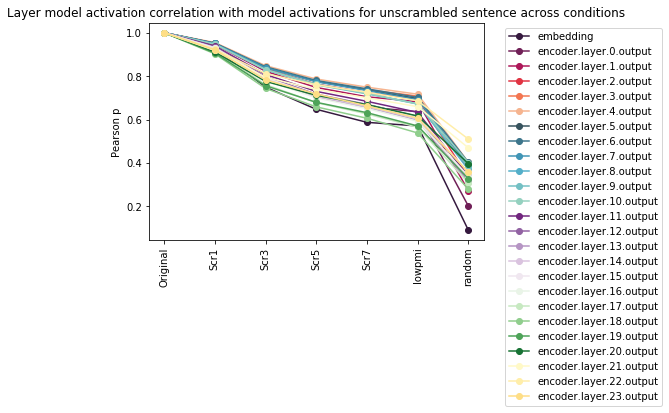

In [69]:
plot_correlations_lineplot('bert-large-uncased-whole-word-masking', bert_layers, bert_conditions, bert_corr_dict)

In [14]:
distilbert_layers, distilbert_conditions, distilbert_corr_dict = get_correlations_df_dict("distilbert-base-uncased")

 17%|█▋        | 1519/8736 [00:00<00:00, 13370.89it/s]

This is the layer I'm looking at:  embeddings


 17%|█▋        | 1521/8736 [00:00<00:00, 14020.96it/s]

This is the layer I'm looking at:  transformer.layer.0


 17%|█▋        | 1521/8736 [00:00<00:00, 13923.71it/s]

This is the layer I'm looking at:  transformer.layer.1


 17%|█▋        | 1521/8736 [00:00<00:00, 14336.26it/s]

This is the layer I'm looking at:  transformer.layer.2


 17%|█▋        | 1521/8736 [00:00<00:00, 13967.30it/s]

This is the layer I'm looking at:  transformer.layer.3


 17%|█▋        | 1518/8736 [00:00<00:00, 10444.01it/s]

This is the layer I'm looking at:  transformer.layer.4


 17%|█▋        | 1521/8736 [00:00<00:00, 14057.69it/s]

This is the layer I'm looking at:  transformer.layer.5


100%|██████████| 8736/8736 [00:18<00:00, 469.52it/s]  


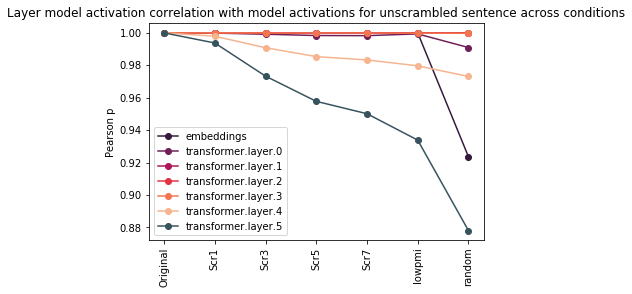

In [15]:
#this is the bidirectional bert version!
plot_correlations_lineplot("distilbert-base-uncased", distilbert_layers, distilbert_conditions, distilbert_corr_dict)

In [22]:
import math
from matplotlib.gridspec import GridSpec

def get_corr_lineplots_loop(model_list):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    #line_colors = sns.color_palette("rocket") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]] + sns.color_palette("GnBu_d")
    #line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    #if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
    #    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
    
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 5*nrows))
    fig2.suptitle('Layer model activation correlation with model activations for unscrambled sentence across conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                model_identifier = model_list[model_counter]
                line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
                if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
                    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
                layers, conditions, correlations_df_dict = get_correlations_df_dict(model_identifier)
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                counter = 0
                for key,value in correlations_df_dict.items():
                    f2_ax[-1].plot(conditions,value, '-o',color=line_colors[counter])
                    counter += 1
                f2_ax[-1].set_title('{}'.format(model_identifier),fontsize=18)
                f2_ax[-1].yaxis.set_label_text('Pearson p')
                #shorten names for legend
                if model_identifier == 'lm_1b':
                    layers = [layer.split('/')[1] for layer in layers]
                if 'albert' in model_identifier:
                    layers = [re.sub('.albert_layer_groups.','.h.', layer) for layer in layers]
                if model_identifier == 'bert-large-uncased-whole-word-masking':
                    layers = ['.'.join(layer.split('.')[:-1]) if '.' in layer else layer for layer in layers]
                f2_ax[-1].legend(layers, bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.xticks(rotation= 90)
                model_counter += 1
    fig2.savefig('fig/final-activations-layer-comparison.png', bbox_inches='tight')


 45%|████▌     | 5547/12265 [00:00<00:00, 53385.45it/s]

This is the layer I'm looking at:  projection



100%|██████████| 12265/12265 [00:10<00:00, 1134.37it/s]

 69%|██████▊   | 8410/12265 [00:00<00:00, 80738.71it/s]

This is the layer I'm looking at:  lstm/lstm_0/control_dependency



100%|██████████| 12265/12265 [00:13<00:00, 895.35it/s]A

 69%|██████▊   | 8404/12265 [00:00<00:00, 67455.10it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency



100%|██████████| 12265/12265 [00:11<00:00, 1082.80it/s]

 80%|███████▉  | 9752/12265 [00:00<00:00, 88338.32it/s]

This is the layer I'm looking at:  encoder



100%|██████████| 12265/12265 [00:16<00:00, 757.51it/s][A

  0%|          | 4/12265 [00:00<06:56, 29.47it/s]

This is the layer I'm looking at:  embeddings



  3%|▎         | 310/12265 [00:16<10:15, 19.42it/s]


  5%|▍         | 613/12265 [00:32<10:27, 18.57it/s]


  7%|▋         | 909/12265 [00:50<11:07, 17.01it/s]


 10%|▉         | 1203/12265 [01:08<11:00, 16.74it/s]


100%|██████████| 12265/12265 [01:17<00:00, 158.46it/s]A

  0%|          | 0/12265 [00:00<?, ?it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.0



  2%|▏         | 299/12265 [00:17<11:36, 17.19it/s]


  5%|▍         | 595/12265 [00:34<10:32, 18.44it/s]


  7%|▋         | 891/12265 [00:50<10:44, 17.66it/s]


 10%|▉         | 1185/12265 [01:07<10:06, 18.26it/s]


100%|██████████| 12265/12265 [01:16<00:00, 160.20it/s]A

  0%|          | 3/12265 [00:00<07:05, 28.82it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.1



  2%|▏         | 301/12265 [00:17<11:21, 17.57it/s]


  5%|▍         | 597/12265 [00:34<10:29, 18.52it/s]


  7%|▋         | 893/12265 [00:50<10:00, 18.95it/s]


 10%|▉         | 1187/12265 [01:07<10:08, 18.21it/s]


100%|██████████| 12265/12265 [01:16<00:00, 159.68it/s]A

  0%|          | 3/12265 [00:00<06:48, 29.98it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.2



  2%|▏         | 301/12265 [00:16<10:56, 18.21it/s]


  5%|▍         | 597/12265 [00:32<10:56, 17.78it/s]


  7%|▋         | 893/12265 [00:49<11:13, 16.88it/s]


 10%|▉         | 1187/12265 [01:06<09:52, 18.71it/s]


100%|██████████| 12265/12265 [01:16<00:00, 161.34it/s]A

  0%|          | 0/12265 [00:00<?, ?it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.3



  2%|▏         | 298/12265 [00:17<11:03, 18.04it/s]


  5%|▍         | 594/12265 [00:33<10:17, 18.90it/s]


  7%|▋         | 890/12265 [00:49<10:15, 18.48it/s]


 10%|▉         | 1184/12265 [01:06<10:54, 16.93it/s]


100%|██████████| 12265/12265 [01:15<00:00, 162.42it/s]A

  0%|          | 0/12265 [00:00<?, ?it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.4



  2%|▏         | 301/12265 [00:16<10:29, 19.00it/s]


  5%|▍         | 597/12265 [00:33<10:57, 17.73it/s]


  7%|▋         | 893/12265 [00:49<10:12, 18.56it/s]


 10%|▉         | 1187/12265 [01:05<10:38, 17.34it/s]


100%|██████████| 12265/12265 [01:14<00:00, 164.33it/s]A

  0%|          | 0/12265 [00:00<?, ?it/s]


This is the layer I'm looking at:  encoder.albert_layer_groups.5


  2%|▏         | 299/12265 [00:16<10:53, 18.30it/s]


  5%|▍         | 595/12265 [00:32<12:07, 16.04it/s]


  7%|▋         | 891/12265 [00:49<11:14, 16.86it/s]


 10%|▉         | 1185/12265 [01:06<10:08, 18.22it/s]


100%|██████████| 12265/12265 [01:16<00:00, 159.92it/s]A

  0%|          | 0/12265 [00:00<?, ?it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.6



  2%|▏         | 299/12265 [00:17<12:03, 16.53it/s]


  5%|▍         | 595/12265 [00:33<10:26, 18.61it/s]


  7%|▋         | 891/12265 [00:49<09:54, 19.12it/s]


 10%|▉         | 1185/12265 [01:05<13:48, 13.38it/s]


100%|██████████| 12265/12265 [01:14<00:00, 163.62it/s]A

  0%|          | 0/12265 [00:00<?, ?it/s]


This is the layer I'm looking at:  encoder.albert_layer_groups.7


  2%|▏         | 304/12265 [00:16<10:51, 18.36it/s]


  5%|▍         | 600/12265 [00:33<11:20, 17.15it/s]


  7%|▋         | 896/12265 [00:50<10:25, 18.17it/s]


 10%|▉         | 1190/12265 [01:06<10:48, 17.09it/s]


100%|██████████| 12265/12265 [01:15<00:00, 163.31it/s]A

  0%|          | 2/12265 [00:00<13:18, 15.35it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.8



  2%|▏         | 300/12265 [00:16<10:21, 19.25it/s]


  5%|▍         | 596/12265 [00:32<10:58, 17.71it/s]


  7%|▋         | 892/12265 [00:48<10:31, 18.02it/s]


 10%|▉         | 1186/12265 [01:05<10:06, 18.26it/s]


100%|██████████| 12265/12265 [01:15<00:00, 162.70it/s]A

  0%|          | 4/12265 [00:00<07:21, 27.79it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.9



  2%|▏         | 302/12265 [00:17<11:23, 17.50it/s]


  5%|▍         | 598/12265 [00:33<12:39, 15.36it/s]


  7%|▋         | 894/12265 [00:49<09:56, 19.08it/s]


 10%|▉         | 1188/12265 [01:05<10:35, 17.44it/s]


100%|██████████| 12265/12265 [01:14<00:00, 165.47it/s]A

  0%|          | 4/12265 [00:00<07:15, 28.16it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.10



  3%|▎         | 309/12265 [00:16<10:21, 19.22it/s]


  5%|▍         | 613/12265 [00:33<12:16, 15.82it/s]


  8%|▊         | 924/12265 [00:49<09:14, 20.44it/s]


 10%|█         | 1275/12265 [01:07<12:40, 14.45it/s]


100%|██████████| 12265/12265 [01:11<00:00, 170.45it/s]A

  0%|          | 0/12265 [00:00<?, ?it/s]

This is the layer I'm looking at:  encoder.albert_layer_groups.11



  3%|▎         | 326/12265 [00:17<09:47, 20.34it/s]


  6%|▌         | 747/12265 [00:38<09:26, 20.34it/s]


  9%|▉         | 1100/12265 [00:56<09:45, 19.06it/s]


100%|██████████| 12265/12265 [01:10<00:00, 174.88it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 11912.48it/s]

This is the layer I'm looking at:  embedding



 19%|█▊        | 2287/12265 [00:30<06:20, 26.25it/s]


100%|██████████| 12265/12265 [00:42<00:00, 286.00it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 13030.92it/s]

This is the layer I'm looking at:  encoder.layer.0.output



 19%|█▉        | 2318/12265 [00:26<04:42, 35.15it/s]


100%|██████████| 12265/12265 [00:37<00:00, 326.03it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12004.14it/s]

This is the layer I'm looking at:  encoder.layer.1.output



100%|██████████| 12265/12265 [00:36<00:00, 337.18it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12593.99it/s]

This is the layer I'm looking at:  encoder.layer.2.output



 19%|█▉        | 2307/12265 [00:27<04:48, 34.51it/s]


100%|██████████| 12265/12265 [00:38<00:00, 322.58it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12501.67it/s]

This is the layer I'm looking at:  encoder.layer.3.output



100%|██████████| 12265/12265 [00:36<00:00, 340.30it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12899.93it/s]

This is the layer I'm looking at:  encoder.layer.4.output



 19%|█▉        | 2316/12265 [00:27<04:52, 33.99it/s]


100%|██████████| 12265/12265 [00:38<00:00, 321.07it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12340.04it/s]

This is the layer I'm looking at:  encoder.layer.5.output



100%|██████████| 12265/12265 [00:36<00:00, 338.02it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 11713.58it/s]

This is the layer I'm looking at:  encoder.layer.6.output



100%|██████████| 12265/12265 [00:36<00:00, 339.40it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12114.22it/s]

This is the layer I'm looking at:  encoder.layer.7.output



100%|██████████| 12265/12265 [00:36<00:00, 338.75it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12336.54it/s]

This is the layer I'm looking at:  encoder.layer.8.output



 19%|█▊        | 2299/12265 [00:28<04:41, 35.39it/s]


100%|██████████| 12265/12265 [00:39<00:00, 310.59it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 13029.96it/s]

This is the layer I'm looking at:  encoder.layer.9.output



 19%|█▉        | 2320/12265 [00:27<04:41, 35.34it/s]


100%|██████████| 12265/12265 [00:38<00:00, 321.86it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12991.54it/s]

This is the layer I'm looking at:  encoder.layer.10.output



 19%|█▉        | 2319/12265 [00:27<04:44, 34.91it/s]


100%|██████████| 12265/12265 [00:38<00:00, 320.40it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12352.35it/s]

This is the layer I'm looking at:  encoder.layer.11.output



 19%|█▉        | 2300/12265 [00:27<04:41, 35.39it/s]


100%|██████████| 12265/12265 [00:38<00:00, 320.41it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12247.91it/s]

This is the layer I'm looking at:  encoder.layer.12.output



100%|██████████| 12265/12265 [00:36<00:00, 337.89it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12655.06it/s]

This is the layer I'm looking at:  encoder.layer.13.output



 19%|█▉        | 2309/12265 [00:27<04:47, 34.65it/s]


100%|██████████| 12265/12265 [00:38<00:00, 321.05it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12712.47it/s]

This is the layer I'm looking at:  encoder.layer.14.output



 19%|█▉        | 2311/12265 [00:27<04:46, 34.70it/s]


100%|██████████| 12265/12265 [00:38<00:00, 321.49it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12706.10it/s]

This is the layer I'm looking at:  encoder.layer.15.output



 19%|█▉        | 2311/12265 [00:27<04:47, 34.65it/s]


100%|██████████| 12265/12265 [00:38<00:00, 320.40it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12623.81it/s]

This is the layer I'm looking at:  encoder.layer.16.output



 19%|█▉        | 2308/12265 [00:27<04:44, 35.00it/s]


100%|██████████| 12265/12265 [00:37<00:00, 323.34it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12151.48it/s]

This is the layer I'm looking at:  encoder.layer.17.output



 19%|█▊        | 2294/12265 [00:27<04:41, 35.48it/s]


100%|██████████| 12265/12265 [00:38<00:00, 316.53it/s][A

 11%|█         | 1349/12265 [00:00<00:00, 12735.39it/s]

This is the layer I'm looking at:  encoder.layer.18.output



 19%|█▉        | 2312/12265 [00:27<04:42, 35.19it/s]


100%|██████████| 12265/12265 [00:38<00:00, 320.87it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 13150.79it/s]

This is the layer I'm looking at:  encoder.layer.19.output



 19%|█▉        | 2324/12265 [00:27<04:59, 33.19it/s]


100%|██████████| 12265/12265 [00:38<00:00, 322.64it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12227.21it/s]

This is the layer I'm looking at:  encoder.layer.20.output



 19%|█▊        | 2296/12265 [00:26<04:38, 35.86it/s]


100%|██████████| 12265/12265 [00:38<00:00, 322.76it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12893.26it/s]

This is the layer I'm looking at:  encoder.layer.21.output



 19%|█▉        | 2316/12265 [00:26<04:34, 36.28it/s]


100%|██████████| 12265/12265 [00:37<00:00, 330.72it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12921.67it/s]

This is the layer I'm looking at:  encoder.layer.22.output



 19%|█▉        | 2317/12265 [00:26<04:41, 35.39it/s]


100%|██████████| 12265/12265 [00:37<00:00, 330.98it/s]A

 11%|█         | 1349/12265 [00:00<00:00, 12899.70it/s]

This is the layer I'm looking at:  encoder.layer.23.output



 19%|█▉        | 2316/12265 [00:27<04:35, 36.12it/s]


100%|██████████| 12265/12265 [00:37<00:00, 326.12it/s]A

 89%|████████▉ | 10925/12265 [00:00<00:00, 88847.04it/s]

This is the layer I'm looking at:  drop



 99%|█████████▊| 12088/12265 [00:32<00:05, 33.85it/s]


100%|██████████| 12265/12265 [00:38<00:00, 321.89it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 98431.83it/s]

This is the layer I'm looking at:  encoder.layer.0



 99%|█████████▉| 12191/12265 [00:31<00:01, 38.62it/s]


100%|██████████| 12265/12265 [00:33<00:00, 361.16it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 97253.37it/s]

This is the layer I'm looking at:  encoder.layer.1



 98%|█████████▊| 11974/12265 [00:26<00:07, 38.82it/s]


100%|██████████| 12265/12265 [00:34<00:00, 355.08it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 95830.06it/s]

This is the layer I'm looking at:  encoder.layer.2



 99%|█████████▉| 12157/12265 [00:31<00:02, 38.65it/s]


100%|██████████| 12265/12265 [00:33<00:00, 362.31it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 98815.60it/s]

This is the layer I'm looking at:  encoder.layer.3



 97%|█████████▋| 11957/12265 [00:26<00:07, 38.69it/s]


100%|██████████| 12265/12265 [00:34<00:00, 358.88it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 97924.04it/s]

This is the layer I'm looking at:  encoder.layer.4



 99%|█████████▉| 12149/12265 [00:31<00:02, 39.08it/s]


100%|██████████| 12265/12265 [00:34<00:00, 357.91it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 95433.29it/s]

This is the layer I'm looking at:  encoder.layer.5



 97%|█████████▋| 11916/12265 [00:25<00:09, 38.30it/s]


100%|██████████| 12265/12265 [00:34<00:00, 355.63it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 97686.06it/s]

This is the layer I'm looking at:  encoder.layer.6



 99%|█████████▊| 12098/12265 [00:29<00:04, 38.44it/s]


100%|██████████| 12265/12265 [00:33<00:00, 363.32it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 97793.22it/s]

This is the layer I'm looking at:  encoder.layer.7



100%|██████████| 12265/12265 [00:33<00:00, 366.27it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 97824.53it/s]

This is the layer I'm looking at:  encoder.layer.8



 99%|█████████▊| 12098/12265 [00:30<00:04, 38.22it/s]


100%|██████████| 12265/12265 [00:34<00:00, 355.25it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 99106.05it/s]

This is the layer I'm looking at:  encoder.layer.9



100%|██████████| 12265/12265 [00:33<00:00, 368.03it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 98961.79it/s]

This is the layer I'm looking at:  encoder.layer.10



 99%|█████████▉| 12117/12265 [00:30<00:03, 38.29it/s]


100%|██████████| 12265/12265 [00:34<00:00, 359.36it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 95786.99it/s]

This is the layer I'm looking at:  encoder.layer.11



 97%|█████████▋| 11903/12265 [00:25<00:09, 37.77it/s]


100%|██████████| 12265/12265 [00:35<00:00, 348.06it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 98818.80it/s]

This is the layer I'm looking at:  encoder.layer.12



 98%|█████████▊| 12051/12265 [00:28<00:05, 38.74it/s]


100%|██████████| 12265/12265 [00:34<00:00, 358.38it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 95323.11it/s]

This is the layer I'm looking at:  encoder.layer.13



100%|█████████▉| 12239/12265 [00:33<00:00, 38.02it/s]


100%|██████████| 12265/12265 [00:33<00:00, 361.73it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 95093.64it/s]

This is the layer I'm looking at:  encoder.layer.14



 98%|█████████▊| 12023/12265 [00:28<00:06, 37.53it/s]


100%|██████████| 12265/12265 [00:34<00:00, 351.94it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 94285.34it/s]

This is the layer I'm looking at:  encoder.layer.15



 99%|█████████▉| 12188/12265 [00:32<00:02, 37.89it/s]


100%|██████████| 12265/12265 [00:34<00:00, 359.14it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 97342.82it/s]

This is the layer I'm looking at:  encoder.layer.16



 98%|█████████▊| 11963/12265 [00:26<00:07, 38.75it/s]


100%|██████████| 12265/12265 [00:34<00:00, 354.23it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 100004.74it/s]

This is the layer I'm looking at:  encoder.layer.17



 99%|█████████▉| 12144/12265 [00:30<00:03, 38.07it/s]


100%|██████████| 12265/12265 [00:33<00:00, 360.74it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 98156.67it/s]

This is the layer I'm looking at:  encoder.layer.18



 97%|█████████▋| 11919/12265 [00:25<00:09, 37.85it/s]


100%|██████████| 12265/12265 [00:34<00:00, 350.58it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 96587.54it/s]

This is the layer I'm looking at:  encoder.layer.19



 99%|█████████▊| 12084/12265 [00:29<00:04, 37.92it/s]


100%|██████████| 12265/12265 [00:34<00:00, 360.00it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 96343.24it/s]

This is the layer I'm looking at:  encoder.layer.20



100%|██████████| 12265/12265 [00:33<00:00, 360.79it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 96891.03it/s]

This is the layer I'm looking at:  encoder.layer.21



 99%|█████████▊| 12096/12265 [00:30<00:04, 36.75it/s]


100%|██████████| 12265/12265 [00:34<00:00, 351.70it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 94250.82it/s]

This is the layer I'm looking at:  encoder.layer.22



100%|██████████| 12265/12265 [00:34<00:00, 359.10it/s][A

 89%|████████▉ | 10925/12265 [00:00<00:00, 95678.39it/s]

This is the layer I'm looking at:  encoder.layer.23



 99%|█████████▊| 12084/12265 [00:29<00:04, 37.75it/s]


100%|██████████| 12265/12265 [00:34<00:00, 353.93it/s][A

 34%|███▍      | 4209/12265 [00:00<00:00, 40168.80it/s]

This is the layer I'm looking at:  drop



100%|██████████| 12265/12265 [00:15<00:00, 767.78it/s]A

 34%|███▍      | 4211/12265 [00:00<00:00, 39614.17it/s]

This is the layer I'm looking at:  encoder.h.0



100%|██████████| 12265/12265 [00:13<00:00, 912.30it/s]A

 34%|███▍      | 4211/12265 [00:00<00:00, 39123.73it/s]

This is the layer I'm looking at:  encoder.h.1



100%|██████████| 12265/12265 [00:13<00:00, 921.93it/s]A

 34%|███▍      | 4211/12265 [00:00<00:00, 38874.36it/s]

This is the layer I'm looking at:  encoder.h.2



100%|██████████| 12265/12265 [00:14<00:00, 863.46it/s]A

 34%|███▍      | 4211/12265 [00:00<00:00, 38561.43it/s]

This is the layer I'm looking at:  encoder.h.3



100%|██████████| 12265/12265 [00:13<00:00, 918.44it/s]A

 34%|███▍      | 4211/12265 [00:00<00:00, 38476.92it/s]

This is the layer I'm looking at:  encoder.h.4



100%|██████████| 12265/12265 [00:13<00:00, 915.40it/s]A

 34%|███▍      | 4211/12265 [00:00<00:00, 39634.08it/s]

This is the layer I'm looking at:  encoder.h.5



100%|██████████| 12265/12265 [00:13<00:00, 898.85it/s]A

 56%|█████▌    | 6896/12265 [00:00<00:00, 60984.90it/s]

This is the layer I'm looking at:  drop



100%|██████████| 12265/12265 [00:22<00:00, 546.46it/s]A

 56%|█████▌    | 6896/12265 [00:00<00:00, 68824.85it/s]

This is the layer I'm looking at:  encoder.h.0



100%|██████████| 12265/12265 [00:19<00:00, 645.18it/s]A

 56%|█████▌    | 6897/12265 [00:00<00:00, 62549.84it/s]

This is the layer I'm looking at:  encoder.h.1



100%|██████████| 12265/12265 [00:18<00:00, 646.73it/s]A

 56%|█████▌    | 6896/12265 [00:00<00:00, 68395.04it/s]

This is the layer I'm looking at:  encoder.h.2



100%|██████████| 12265/12265 [00:19<00:00, 643.67it/s]A

 56%|█████▌    | 6896/12265 [00:00<00:00, 68712.53it/s]

This is the layer I'm looking at:  encoder.h.3



100%|██████████| 12265/12265 [00:19<00:00, 625.14it/s]A

 56%|█████▌    | 6897/12265 [00:00<00:00, 63058.42it/s]

This is the layer I'm looking at:  encoder.h.4



100%|██████████| 12265/12265 [00:18<00:00, 648.18it/s]A

 56%|█████▌    | 6896/12265 [00:00<00:00, 66818.18it/s]

This is the layer I'm looking at:  encoder.h.5



100%|██████████| 12265/12265 [00:18<00:00, 648.28it/s]A

 56%|█████▌    | 6896/12265 [00:00<00:00, 68281.53it/s]

This is the layer I'm looking at:  encoder.h.6



100%|██████████| 12265/12265 [00:18<00:00, 653.95it/s]A

 56%|█████▌    | 6896/12265 [00:00<00:00, 66963.28it/s]

This is the layer I'm looking at:  encoder.h.7



100%|██████████| 12265/12265 [00:18<00:00, 647.76it/s]A

 56%|█████▌    | 6897/12265 [00:00<00:00, 60251.09it/s]

This is the layer I'm looking at:  encoder.h.8



100%|██████████| 12265/12265 [00:18<00:00, 662.43it/s] 

 56%|█████▌    | 6897/12265 [00:00<00:00, 62112.55it/s]

This is the layer I'm looking at:  encoder.h.9



100%|██████████| 12265/12265 [00:19<00:00, 633.54it/s] 

 56%|█████▌    | 6897/12265 [00:00<00:00, 62622.69it/s]

This is the layer I'm looking at:  encoder.h.10



100%|██████████| 12265/12265 [00:18<00:00, 666.13it/s] 

 56%|█████▌    | 6896/12265 [00:00<00:00, 66709.54it/s]

This is the layer I'm looking at:  encoder.h.11



100%|██████████| 12265/12265 [00:19<00:00, 644.79it/s]A


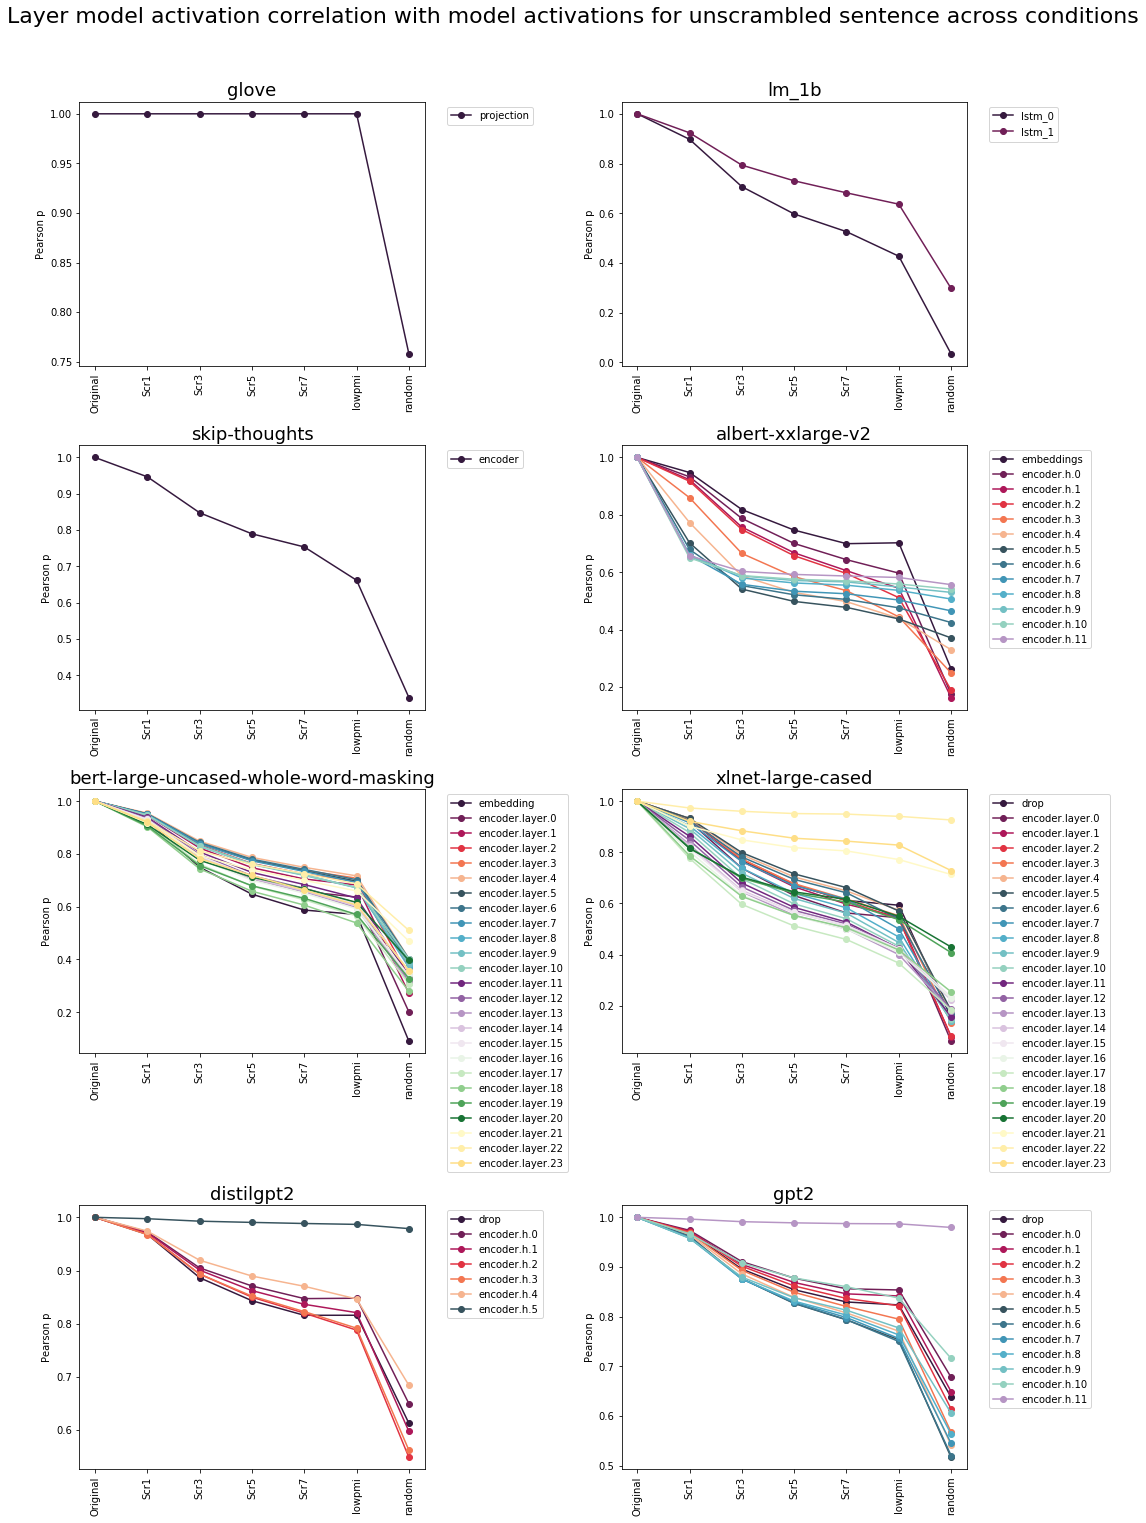

In [24]:
get_corr_lineplots_loop(['glove','lm_1b','skip-thoughts', 'albert-xxlarge-v2','bert-large-uncased-whole-word-masking', 'xlnet-large-cased', 'distilgpt2', 'gpt2']) #'distilbert-base-uncased'